In [38]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                 'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                 'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                 'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                 '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                  "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                  'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                  'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                  '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl', 'wdw','disneylandparis',
                  'theme_park', 'min', 'day', 'new', 'guy', 'year', 'way', 'part', 'thing', 'man','ティスニー',
                  'side', 'sia', 'ティスニーラント', 'ティスニーハロウィーン', 'today', 'wanna', 'place',
                  'world', 'disneyworld', 'next', 'disneypark', '東京ティスニーシー', 'yen',
                  '東京ティスニーラント', 'land', 'park', 'ティスニーシー', 'tdl', 'tdrmd', 'lot',
                  "東京ティスニーリソート"])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [39]:
df = pd.read_json('DiSmldata.json')

In [40]:
df_en_pos = df[(df['label'] == 5)]

In [41]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_en_pos.clean_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['why', 'would', 'disney', 'need', 'promote', 'starwars', 'galaxysedge', 'much', 'everything', 'hunkydory']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases. Must show up more than 2 times the phrases 
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [43]:
data_ready[0:10]

[['would', 'need', 'promote', 'much', 'everything', 'hunkydory'],
 ['enter'],
 ['would', 'need', 'promote', 'much', 'everything', 'hunkydory'],
 ['spa',
  'resort',
  'introduce',
  'allnew',
  'upscale',
  'experience',
  'tenaya_stone',
  'spa',
  'opening_spring'],
 ['thegoldbergsabc',
  'vacation',
  'mode',
  'head',
  'join',
  'special',
  'sneak_peek',
  'vacation',
  'episode',
  'main_street',
  'opera_house',
  'pm',
  'road_trip',
  'want',
  'miss',
  'registration',
  'require'],
 ['deep', 'conversation', 'best'],
 ['week', 'fast', 'even', 'faster', 'would', 'great'],
 ['mickey_floral',
  'return',
  'bit',
  'small',
  'use',
  'still',
  'gorgeous',
  'though'],
 ['head',
  'flockpresent',
  'see',
  'love',
  'fun',
  'lately',
  'pthdisney',
  'disneysmc',
  'thank',
  'host'],
 ['cant_wait',
  'harmony',
  'word',
  'start',
  'go',
  'group',
  'kindre',
  'sing',
  'acapella',
  'song',
  'together',
  'smule',
  'deep',
  'meaning',
  'progress',
  'harmony',
  'p

In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [45]:
#3 Topics
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [46]:
pprint(lda_model3.print_topics())

[(0,
  '0.058*"halloween" + 0.036*"go" + 0.028*"happy_halloween" + 0.011*"great" + '
  '0.010*"would" + 0.010*"favorite" + 0.010*"amazing" + 0.010*"thank" + '
  '0.009*"need" + 0.007*"resort"'),
 (1,
  '0.032*"love" + 0.020*"see" + 0.018*"ride" + 0.014*"fun" + 0.012*"look" + '
  '0.011*"come" + 0.011*"think" + 0.010*"work" + 0.008*"well" + 0.008*"right"'),
 (2,
  '0.031*"time" + 0.021*"happy" + 0.021*"get" + 0.019*"good" + 0.017*"take" + '
  '0.016*"make" + 0.013*"lol" + 0.011*"trip" + 0.011*"want" + 0.010*"really"')]


In [47]:
#4 Topics
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [48]:
pprint(lda_model4.print_topics())

[(0,
  '0.017*"great" + 0.016*"would" + 0.016*"favorite" + 0.015*"amazing" + '
  '0.014*"need" + 0.011*"still" + 0.010*"show" + 0.009*"home" + 0.009*"back" + '
  '0.008*"even"'),
 (1,
  '0.042*"love" + 0.027*"see" + 0.023*"ride" + 0.019*"fun" + 0.015*"look" + '
  '0.014*"think" + 0.013*"thank" + 0.013*"work" + 0.011*"right" + '
  '0.011*"much"'),
 (2,
  '0.043*"time" + 0.030*"happy" + 0.029*"get" + 0.024*"take" + 0.023*"make" + '
  '0.019*"lol" + 0.015*"want" + 0.014*"really" + 0.014*"adventure" + '
  '0.013*"say"'),
 (3,
  '0.074*"halloween" + 0.046*"go" + 0.036*"happy_halloween" + 0.023*"good" + '
  '0.014*"come" + 0.013*"trip" + 0.010*"everyone" + 0.010*"happyhalloween" + '
  '0.009*"resort" + 0.008*"first_time"')]


In [49]:
#5 Topics
lda_model5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [50]:
pprint(lda_model5.print_topics())

[(0,
  '0.075*"go" + 0.022*"great" + 0.021*"would" + 0.020*"amazing" + 0.012*"end" '
  '+ 0.011*"even" + 0.011*"theme" + 0.010*"week" + 0.010*"together" + '
  '0.010*"share"'),
 (1,
  '0.053*"happy_halloween" + 0.032*"ride" + 0.021*"look" + 0.020*"think" + '
  '0.019*"favorite" + 0.015*"right" + 0.014*"cute" + 0.014*"friend" + '
  '0.013*"photo" + 0.012*"may"'),
 (2,
  '0.048*"time" + 0.033*"happy" + 0.033*"get" + 0.027*"take" + 0.025*"make" + '
  '0.021*"lol" + 0.016*"want" + 0.015*"really" + 0.015*"adventure" + '
  '0.015*"say"'),
 (3,
  '0.109*"halloween" + 0.015*"well" + 0.014*"resort" + 0.012*"know" + '
  '0.012*"show" + 0.011*"first_time" + 0.011*"christmas" + 0.010*"tonight" + '
  '0.009*"hauntedmansion" + 0.009*"experience"'),
 (4,
  '0.054*"love" + 0.034*"see" + 0.031*"good" + 0.024*"fun" + 0.019*"come" + '
  '0.018*"trip" + 0.017*"thank" + 0.016*"work" + 0.016*"need" + '
  '0.014*"everyone"')]


In [51]:
#6 Topics
lda_model6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [52]:
pprint(lda_model6.print_topics())

[(0,
  '0.034*"favorite" + 0.024*"still" + 0.021*"show" + 0.020*"back" + '
  '0.015*"something" + 0.015*"find" + 0.014*"live" + 0.014*"hotel" + '
  '0.013*"anaheim" + 0.012*"tour"'),
 (1,
  '0.067*"love" + 0.042*"see" + 0.030*"fun" + 0.022*"want" + 0.021*"thank" + '
  '0.020*"adventure" + 0.015*"photo" + 0.014*"first" + 0.013*"also" + '
  '0.013*"old"'),
 (2,
  '0.060*"time" + 0.042*"happy" + 0.041*"get" + 0.034*"take" + 0.032*"make" + '
  '0.026*"lol" + 0.019*"really" + 0.019*"say" + 0.018*"hope" + 0.017*"well"'),
 (3,
  '0.148*"halloween" + 0.019*"resort" + 0.016*"know" + 0.015*"first_time" + '
  '0.015*"christmas" + 0.012*"together" + 0.012*"experience" + 0.010*"wear" + '
  '0.010*"beautiful" + 0.009*"mean"'),
 (4,
  '0.024*"come" + 0.024*"great" + 0.023*"trip" + 0.023*"would" + '
  '0.021*"amazing" + 0.021*"need" + 0.018*"everyone" + 0.017*"much" + '
  '0.015*"wish" + 0.012*"magic"'),
 (5,
  '0.068*"go" + 0.053*"happy_halloween" + 0.033*"good" + 0.032*"ride" + '
  '0.021*"look" + 0

In [53]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, dictionary=lda_model3.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.284687 -0.004953       1        1  35.413380
1      0.146798 -0.234958       2        1  34.012108
0      0.137889  0.239911       3        1  30.574518, topic_info=      Category         Freq             Term        Total  loglift  logprob
235    Default  3863.000000        halloween  3863.000000  30.0000  30.0000
58     Default  2401.000000               go  2401.000000  29.0000  29.0000
52     Default  2370.000000             love  2370.000000  28.0000  28.0000
88     Default  2389.000000             time  2389.000000  27.0000  27.0000
4070   Default  1873.000000  happy_halloween  1873.000000  26.0000  26.0000
...        ...          ...              ...          ...      ...      ...
559     Topic3   220.429749            watch   221.131317   1.1818  -5.7156
213     Topic3   261.022064             wear   261.879059   1.1817  -5.5466
68      Topic3   243.992172            start   244.806396   1.1817  -5.6141
3175    Topic3   236.101959          support   238.033615   1.1769  -5.6469
11505   Topic3   423.124298   happyhalloween   566.197449   0.8937  -5.0635

[129 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
227       1  0.998424  adventure
1039      2  0.997451    already
577       2  0.998526       also
995       3  0.997907     always
367       3  0.998822    amazing
...     ...       ...        ...
38        3  0.996928       week
180       2  0.999350       well
791       1  0.999413       wish
253       2  0.998690       work
5         3  0.998743      would

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [54]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model6, corpus, dictionary=lda_model6.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.068509  0.361269       1        1  19.454035
5     -0.366006 -0.010232       2        1  19.254599
4      0.077040 -0.152423       3        1  18.697254
1      0.155031 -0.079291       4        1  17.812777
3      0.042707 -0.087500       5        1  12.776680
0      0.022718 -0.031824       6        1  12.004646, topic_info=     Category         Freq             Term        Total  loglift  logprob
235   Default  4125.000000        halloween  4125.000000  30.0000  30.0000
58    Default  2864.000000               go  2864.000000  29.0000  29.0000
52    Default  2600.000000             love  2600.000000  28.0000  28.0000
88    Default  2576.000000             time  2576.000000  27.0000  27.0000
4070  Default  2234.000000  happy_halloween  2234.000000  26.0000  26.0000
...       ...          ...              ...          ...      ...      ...
1833   Topic6   149.363846          america   150.209702   2.1142  -5.1699
4746   Topic6   167.368378   disneyprincess   168.354752   2.1140  -5.0561
465    Topic6   156.183792             tune   157.111542   2.1140  -5.1253
40     Topic6   162.811966         gorgeous   165.115585   2.1058  -5.0837
9540   Topic6   154.723038          cypress   212.252487   1.8037  -5.1347

[216 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
227       4  0.999113  adventure
1039      4  0.996540    already
577       4  0.998198       also
995       3  0.996504     always
367       3  0.999021    amazing
...     ...       ...        ...
791       3  0.999045       wish
643       4  0.994345  wonderful
253       2  0.998360       work
5         3  0.999141      would
683       3  0.996786  yesterday

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 2, 4, 1])

In [55]:
#10 Topics
lda_model10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [56]:
pprint(lda_model10.print_topics())

[(0,
  '0.130*"go" + 0.040*"come" + 0.021*"end" + 0.021*"home" + 0.020*"magic" + '
  '0.020*"theme" + 0.017*"night" + 0.015*"party" + 0.015*"excited" + '
  '0.014*"october"'),
 (1,
  '0.000*"emporium" + 0.000*"discoverdlppod" + 0.000*"tadpn" + '
  '0.000*"entertain" + 0.000*"maaayyne" + 0.000*"wouldve_loved" + '
  '0.000*"snapshot" + 0.000*"veal" + 0.000*"must_nice" + 0.000*"mego"'),
 (2,
  '0.000*"emporium" + 0.000*"discoverdlppod" + 0.000*"tadpn" + '
  '0.000*"entertain" + 0.000*"maaayyne" + 0.000*"wouldve_loved" + '
  '0.000*"snapshot" + 0.000*"veal" + 0.000*"must_nice" + 0.000*"mego"'),
 (3,
  '0.000*"emporium" + 0.000*"discoverdlppod" + 0.000*"tadpn" + '
  '0.000*"entertain" + 0.000*"maaayyne" + 0.000*"wouldve_loved" + '
  '0.000*"snapshot" + 0.000*"veal" + 0.000*"must_nice" + 0.000*"mego"'),
 (4,
  '0.096*"halloween" + 0.049*"time" + 0.047*"happy_halloween" + 0.028*"ride" + '
  '0.021*"lol" + 0.018*"great" + 0.017*"trip" + 0.017*"would" + '
  '0.017*"favorite" + 0.016*"amazing"')

In [59]:
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model10, corpus, dictionary=lda_model10.id2word)
# vis

In [ ]:
#5 topics seem to be best

In [60]:
#Final Model 


#5 Topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [61]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5417,"love, see, good, fun, come, trip, thank, need,...","[would, need, promote, much, everything, hunky..."
1,1,0.0,0.5999,"look, great, think, would, amazing, work, well...",[enter]
2,2,4.0,0.5417,"love, see, good, fun, come, trip, thank, need,...","[would, need, promote, much, everything, hunky..."
3,3,3.0,0.7218,"halloween, go, ride, favorite, resort, photo, ...","[spa, resort, introduce, allnew, upscale, expe..."
4,4,1.0,0.5288,"happy_halloween, want, adventure, last, first,...","[thegoldbergsabc, vacation, mode, head, join, ..."
5,5,4.0,0.7989,"love, see, good, fun, come, trip, thank, need,...","[deep, conversation, best]"
6,6,0.0,0.7230,"look, great, think, would, amazing, work, well...","[week, fast, even, faster, would, great]"
7,7,4.0,0.4014,"love, see, good, fun, come, trip, thank, need,...","[mickey_floral, return, bit, small, use, still..."
8,8,4.0,0.7903,"love, see, good, fun, come, trip, thank, need,...","[head, flockpresent, see, love, fun, lately, p..."
9,9,3.0,0.5010,"halloween, go, ride, favorite, resort, photo, ...","[cant_wait, harmony, word, start, go, group, k..."


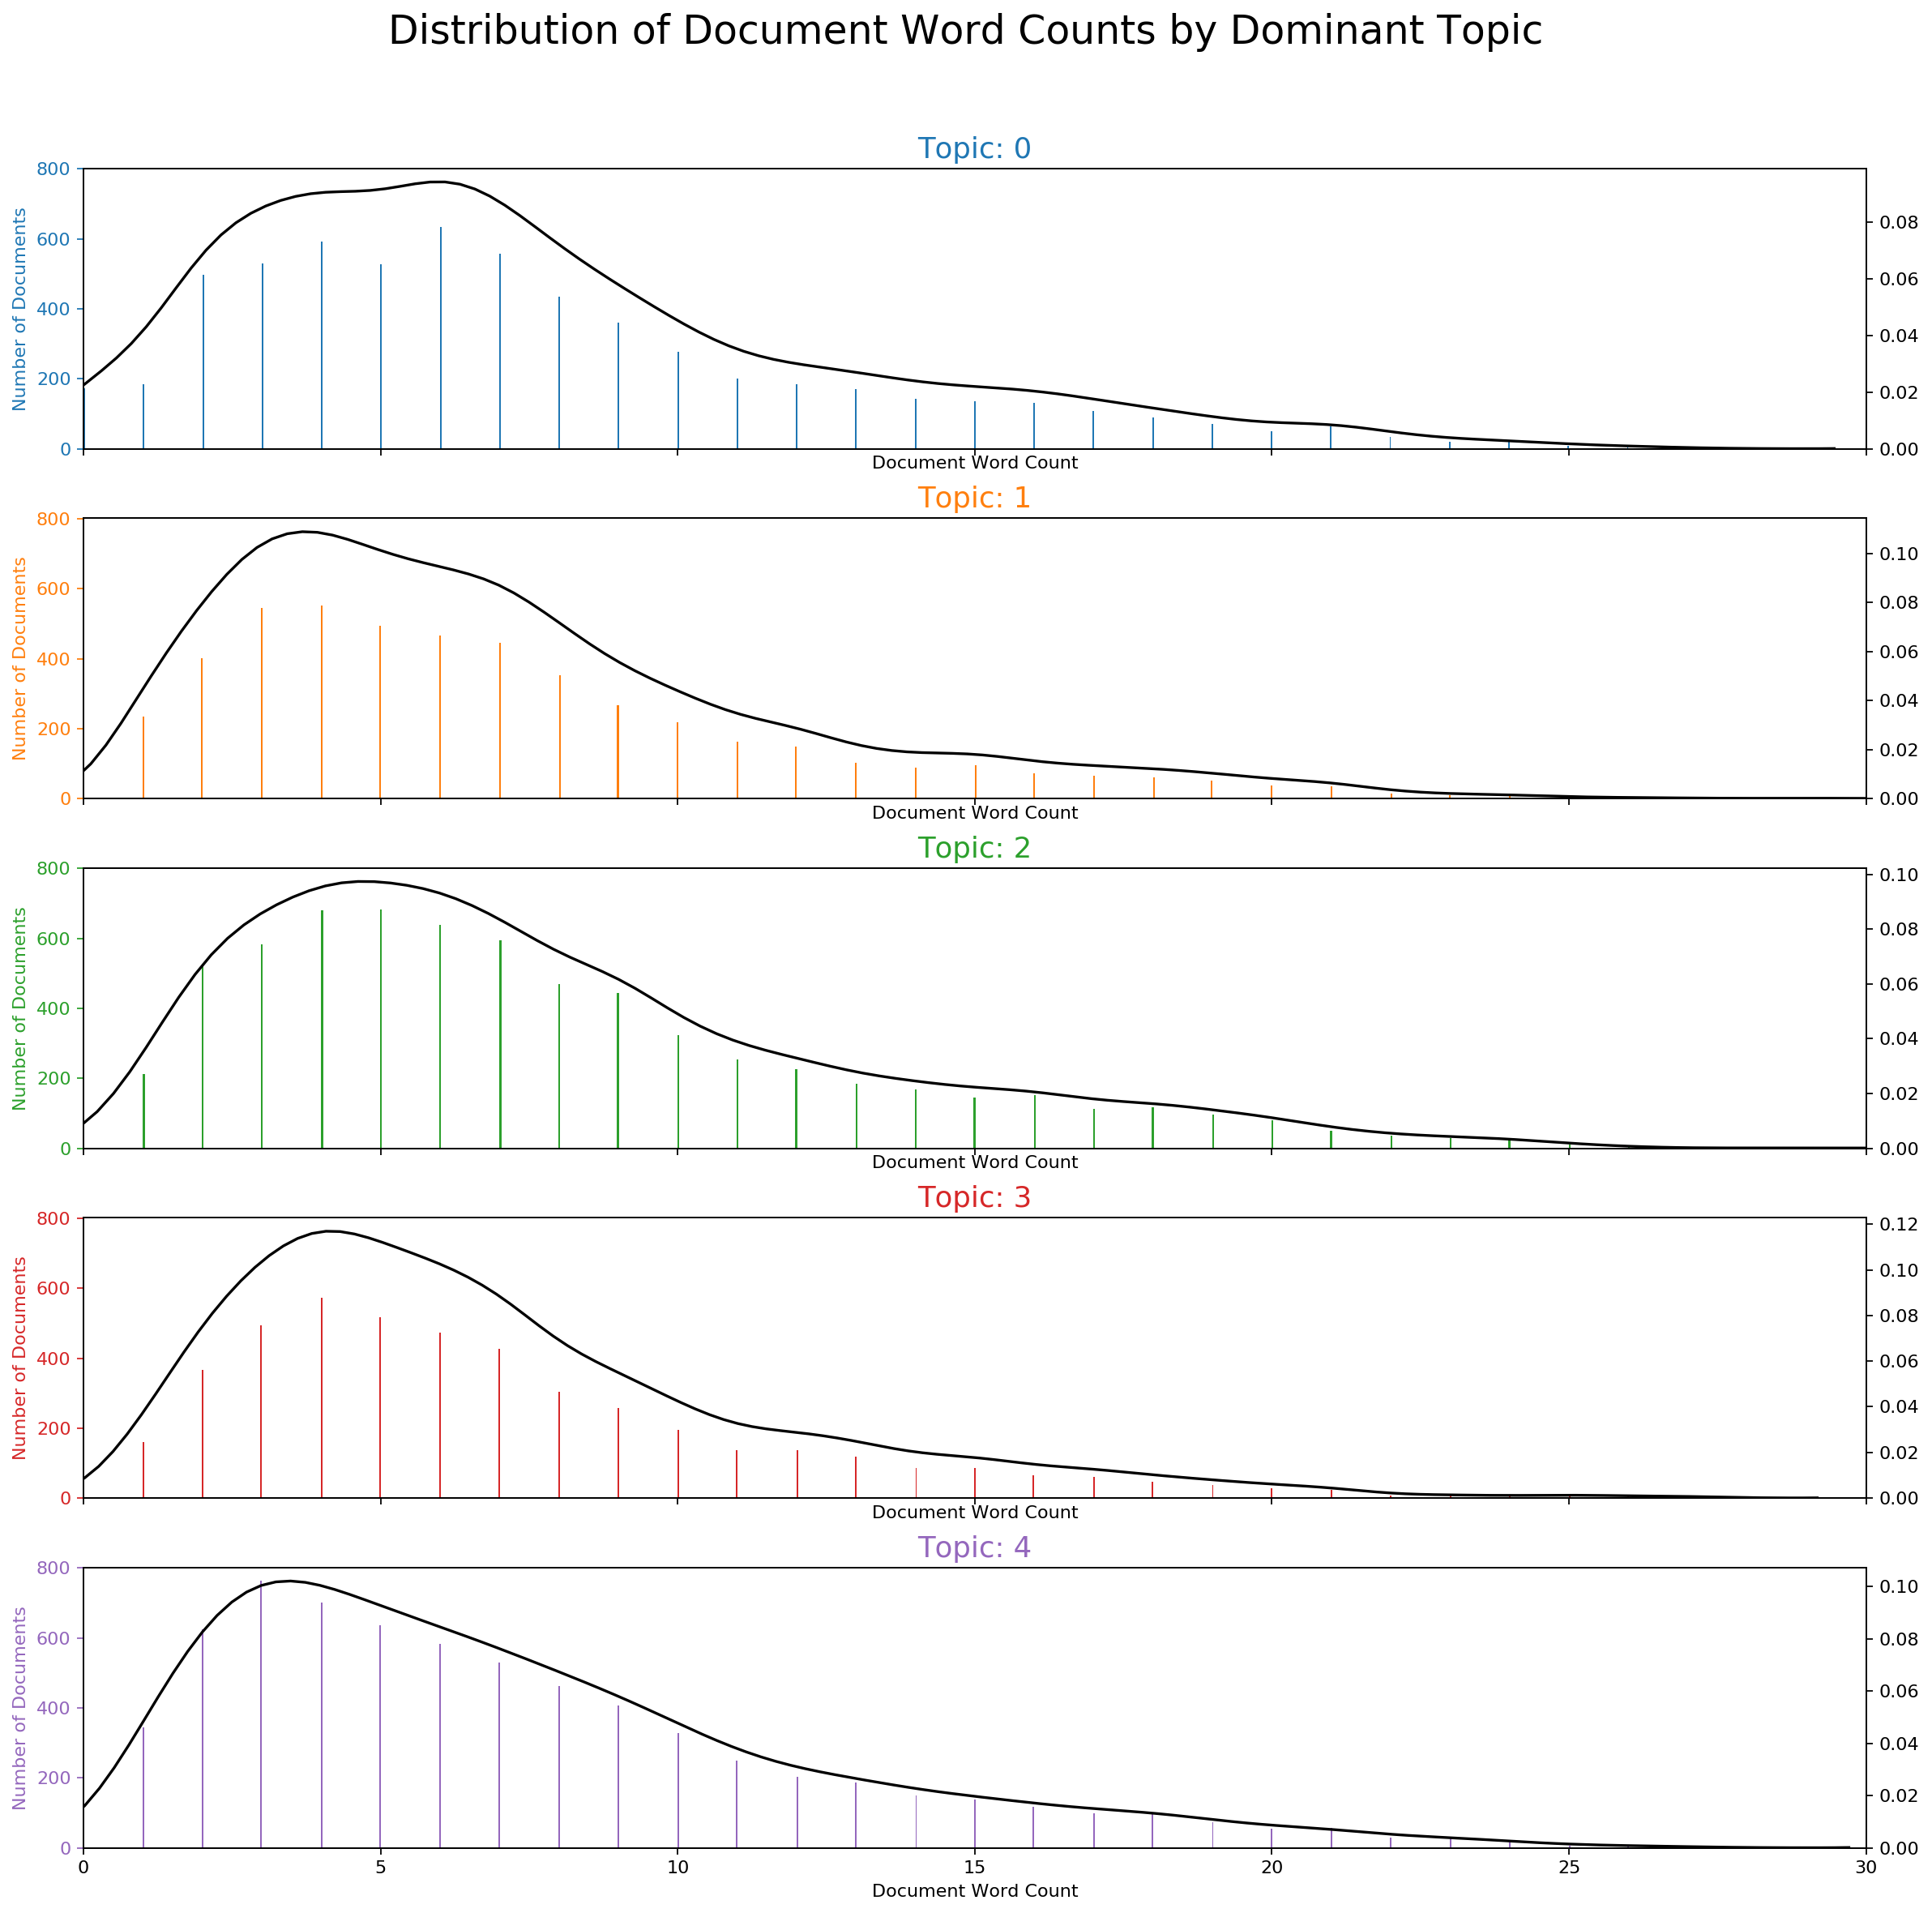

In [62]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,1,figsize=(15,15), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

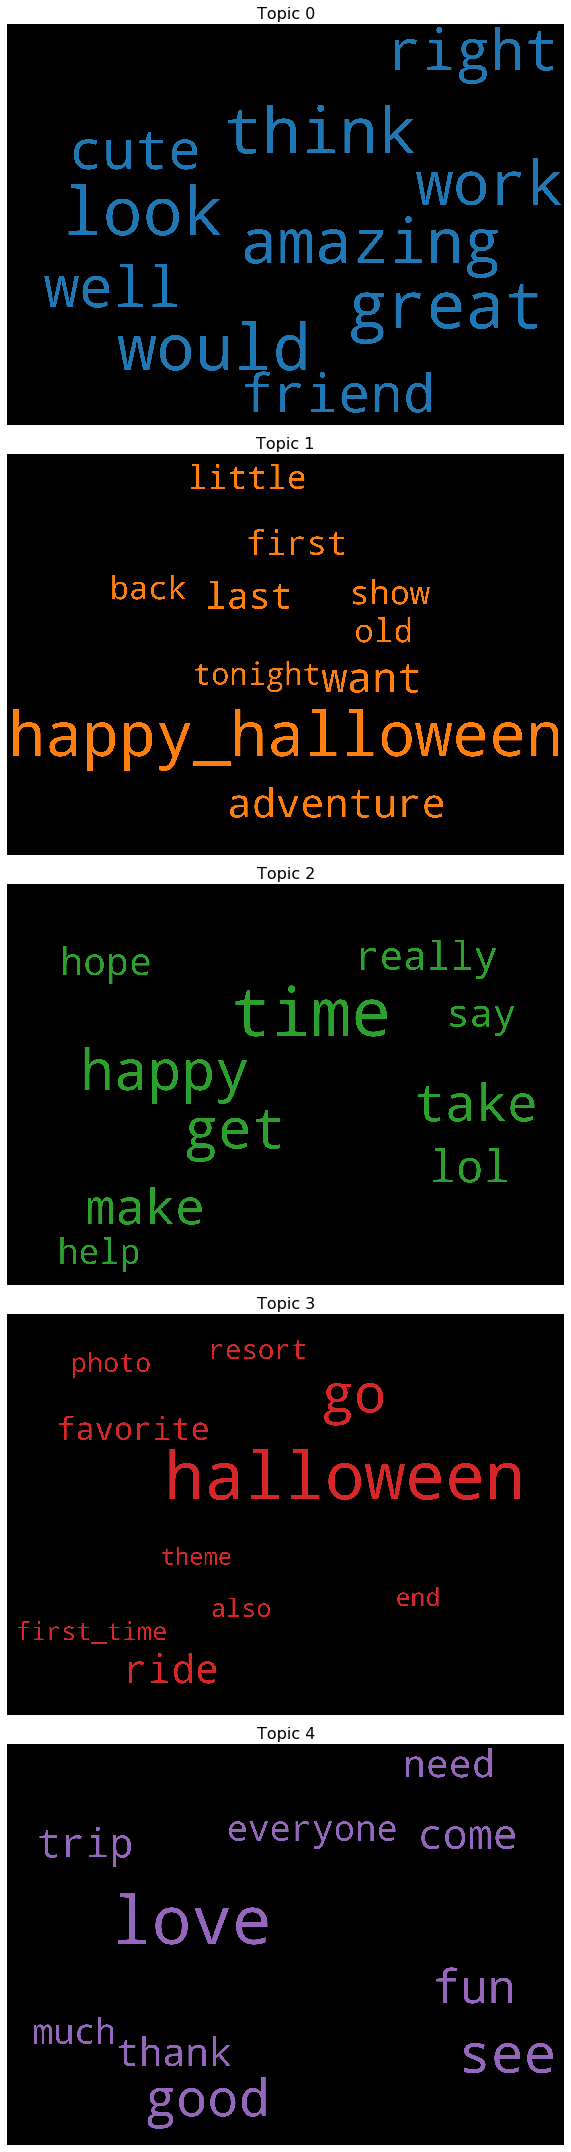

In [63]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

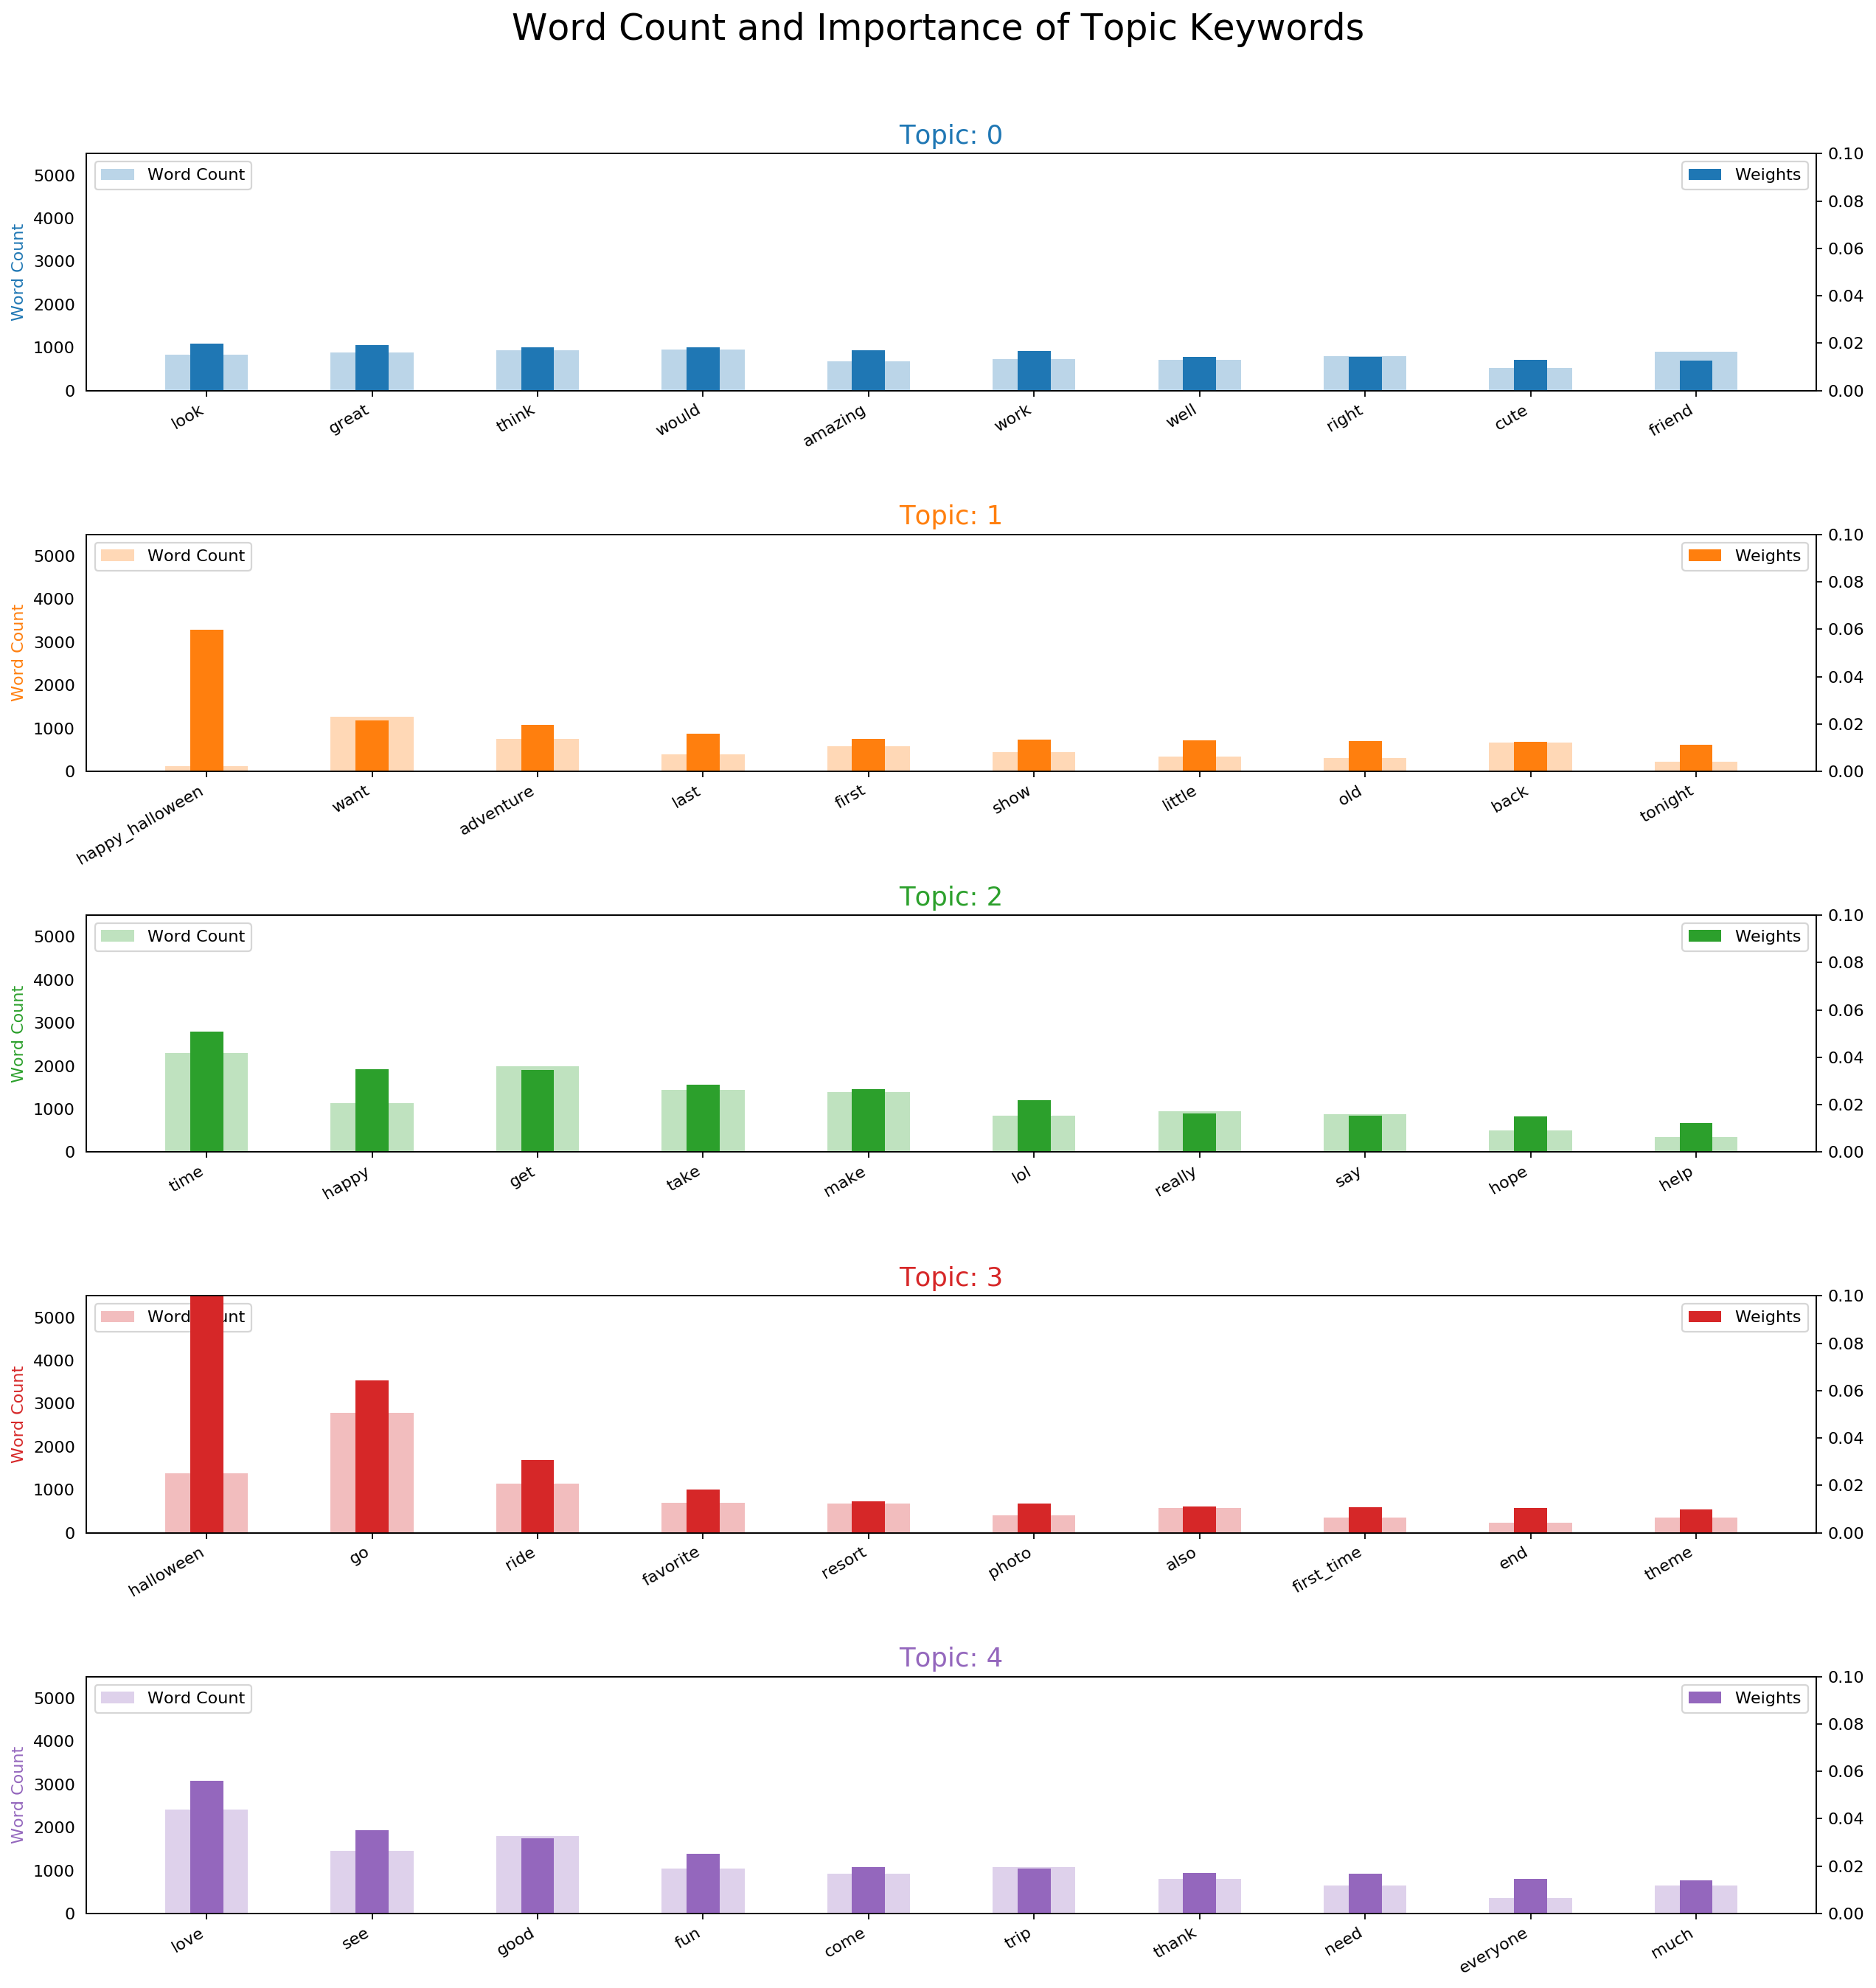

In [64]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [65]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

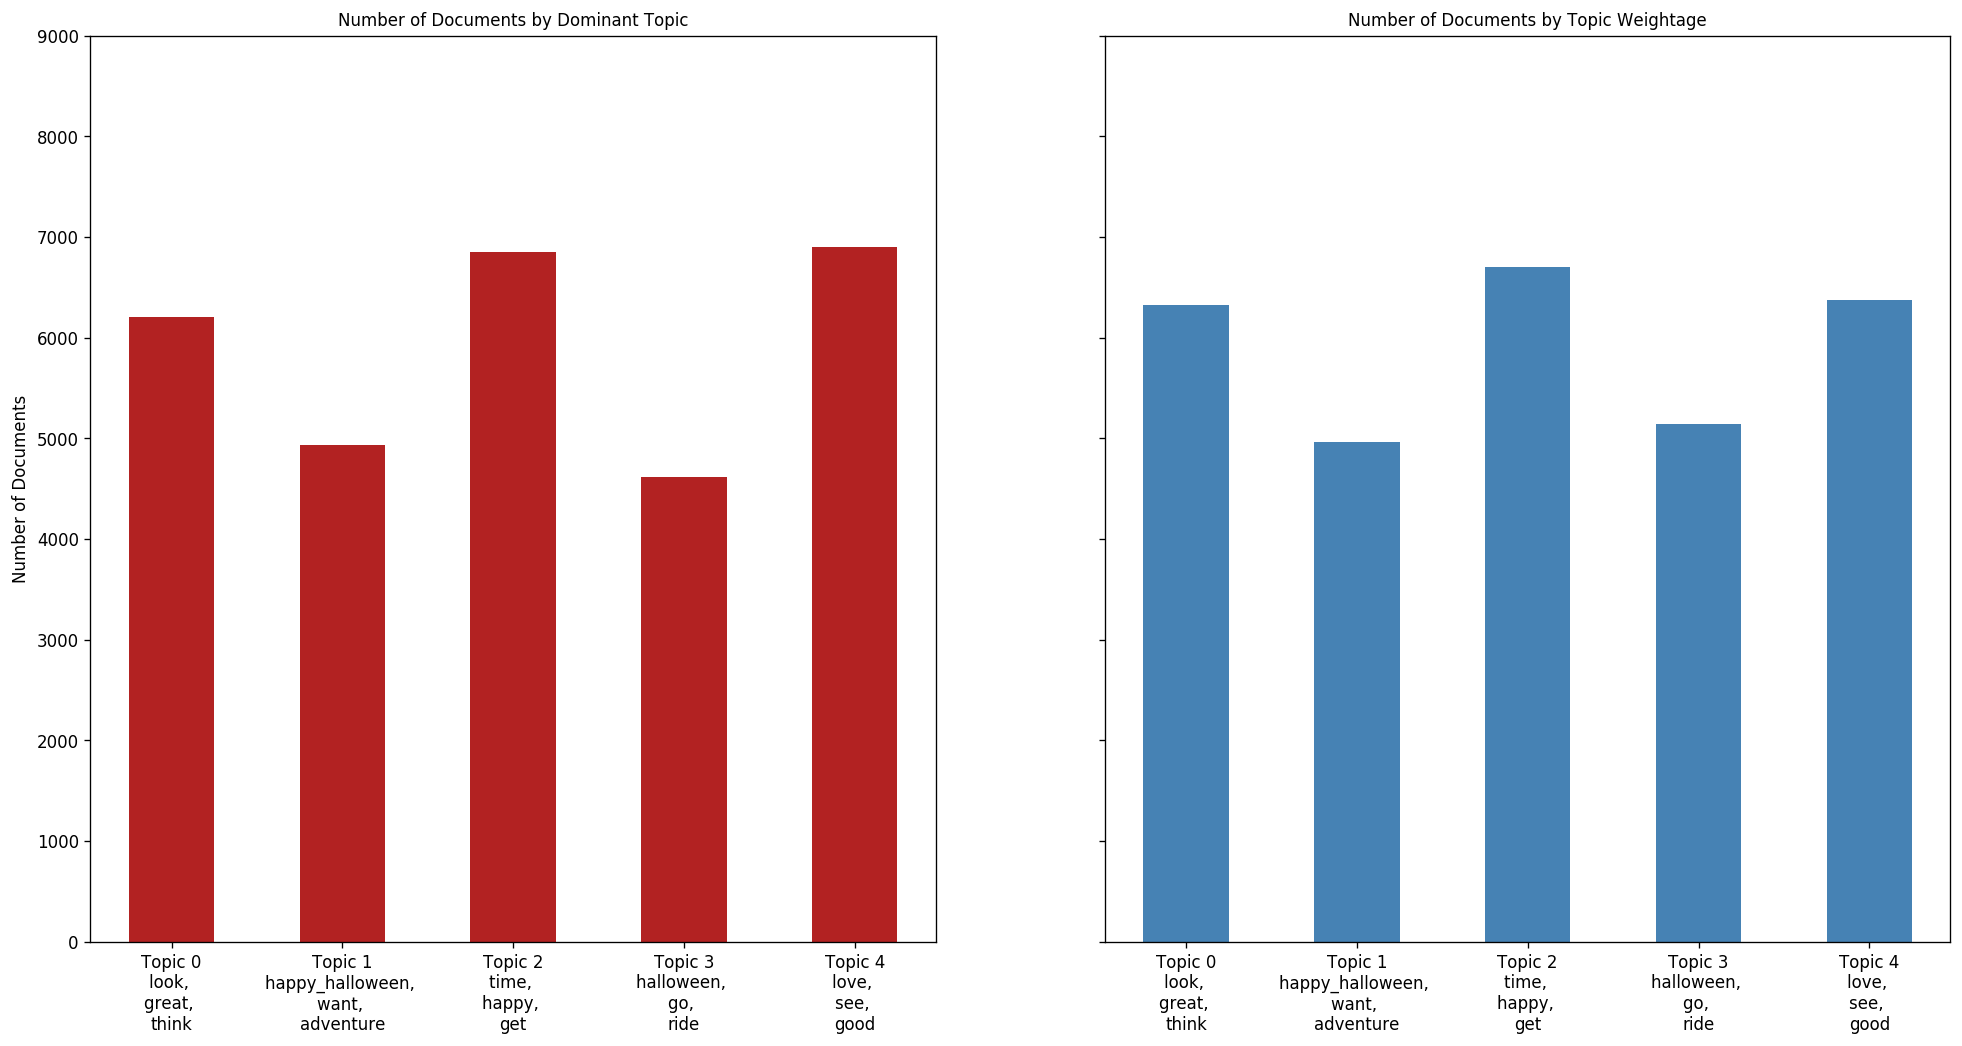

In [66]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 9000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [67]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state= 77, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23636 samples in 0.018s...
[t-SNE] Computed neighbors for 23636 samples in 1.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23636
[t-SNE] Computed conditional probabilities for sample 2000 / 23636
[t-SNE] Computed conditional probabilities for sample 3000 / 23636
[t-SNE] Computed conditional probabilities for sample 4000 / 23636
[t-SNE] Computed conditional probabilities for sample 5000 / 23636
[t-SNE] Computed conditional probabilities for sample 6000 / 23636
[t-SNE] Computed conditional probabilities for sample 7000 / 23636
[t-SNE] Computed conditional probabilities for sample 8000 / 23636
[t-SNE] Computed conditional probabilities for sample 9000 / 23636
[t-SNE] Computed conditional probabilities for sample 10000 / 23636
[t-SNE] Computed conditional probabilities for sample 11000 / 23636
[t-SNE] Computed conditional probabilities for sample 12000 / 23636
[t-SNE] Computed conditional probabilities for sam

In [68]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [69]:
num_topics = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

look                 0.020
great                0.019
think                0.018
would                0.018
amazing              0.017
work                 0.017
well                 0.014
right                0.014
cute                 0.013
friend               0.013
Topic 1 |---------------------

happy_halloween      0.060
want                 0.021
adventure            0.020
last                 0.016
first                0.014
show                 0.013
little               0.013
old                  0.013
back                 0.012
tonight              0.011
Topic 2 |---------------------

time                 0.051
happy                0.035
get                  0.035
take                 0.029
make                 0.027
lol                  0.022
really               0.016
say                  0.016
hope                 0.015
help                 0.012
Topic 3 |---------------------

halloween            0.104
go 

In [70]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700,tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

In [71]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.342826  0.059943       1        1  23.067616
0     -0.013642 -0.029926       2        1  21.738533
4     -0.060539 -0.309319       3        1  21.474169
3     -0.149865  0.209386       4        1  16.911570
1     -0.118780  0.069917       5        1  16.808111, topic_info=     Category         Freq             Term        Total  loglift  logprob
235   Default  3839.000000        halloween  3839.000000  30.0000  30.0000
58    Default  2385.000000               go  2385.000000  29.0000  29.0000
52    Default  2629.000000             love  2629.000000  28.0000  28.0000
4070  Default  2194.000000  happy_halloween  2194.000000  27.0000  27.0000
88    Default  2562.000000             time  2562.000000  26.0000  26.0000
...       ...          ...              ...          ...      ...      ...
745    Topic5   238.462173             cool   239.256638   1.7800  -5.0387
672    Topic5   233.048782         birthday   233.839767   1.7799  -5.0616
420    Topic5   226.279892             lmao   227.053711   1.7799  -5.0911
297    Topic5   218.564697            https   219.353088   1.7797  -5.1258
1734   Topic5   217.632126          believe   218.428101   1.7797  -5.1301

[182 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
227       5  0.999381  adventure
1039      4  0.998211    already
577       4  0.999142       also
995       3  0.997906     always
367       2  0.998849    amazing
...     ...       ...        ...
791       1  0.999422       wish
643       3  0.996478  wonderful
253       2  0.998869       work
5         2  0.998998      would
683       3  0.995979  yesterday

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])